# Asynchronous communication

In general speaking, asynchronous communication is when you send a message without expecting an immediate response. For example, you send an email. I open and respond to the email several hours later. In contrast, synchronous communication is when you send a message and the recipient processes the information immediately. All previous communications are synchronous communications because all agents have to actively involved with the communication operation in the same time. It is common in cluster and HPC since the computers are dedicated to do one thing at one time. Then, why do we care about the asynchronous communication?

The main advantages of asynchronous communication over the synchronous communication is it can avoid the idel times.
In the synchronous communication pattern, all agents has to start and end the communication at the same time. If some agents is delayed, all others have to wait for that one. On the other hand, the asynchronous communication eventible bought more complexity into the code and you may also face some data racing problem.
Bluefog provided the convenient functionality for asynchronous communication. We will use the examples to show the traits of asynchronous communication.

There are two main goals of this notebook. The first is to introduce the asynchronous communication in BlueFog. In order to achieve that, we have to introduce the concept the `window`, whihc is an area of memory, which follows some protocols that allow others to modify it. The modification operation, i.e. data transfer, is called one-sided communication. Second, we will revisit the average consensus and push-sum algorithm and exam them under the asynchronous situation. You see the behavior of the same algorithm under synchronous and asynchronous scenario may differ.

In [1]:
import torch
import networkx as nx
import ipyparallel as ipp
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
rc = ipp.Client(profile="bluefog")
rc.block=True
rc.ids

[0, 1, 2, 3]

In [4]:
%%px
import torch
import bluefog.torch as bf

bf.init()

# Asynchronous Operation in BlueFog

Asynchronous operation may have different meaning in different context. 
> In BlueFog, *asynchronous operation* means the operation executing in agent $k$ is independent from the operation running in  other agent $k'$. 

*Note the difference between the asynchronous operation and nonblocking operation introduced before.*

For example, `neighbor_allreduce()` is NOT asynchronous operation because it will be finished in agent $k$ only when the other agents $k'$ finished the call as well. In other words, all collective communication operation in BlueFog is classified as *synchronous* operation. Similarly, the basic send-recieve communication pair can be the asynchronous operation since the send operation in agent $k$ is dependent in the recieve operation of other agent.


BlueFog built the asynchronous operation and algorithm is based upon the *One-sided communication ops*, which is introduced in MPI-2. The most notable feature of one-sided communication is indicated by the name that allows the communication ops of one process to be decoupled from the behavior of another process. [Here](https://pages.tacc.utexas.edu/~eijkhout/pcse/html/mpi-onesided.html) is a nice introduction for the MPI one-sided communication ops.  

This decoupled behavior can bring us several of benefits. For instance, under heterogenous environment, some agent may have better hardware and some get worse one. For example, you may have several GPUs but some were bought with latest model but some were bought years ago. Hence, the computation time can vary among agents. Under the one-sided communications, every one can immediately continue the process without awaiting.


Now, we formally introduce the asynchronous operation in BlueFog. The first concept is called **window**. A window in each processor (agent) is an area of memory, available to one-sided transfers.

<img src="one-sided-window.jpeg" alt="window.jpeg" width="700"/>

Therefore, creating a window is always the first step to use the one-sided communication.
In Bluefog, each window must be associated with a unique name, which will be the identity to operate the window in the future. The following example shows how you can create a window named `x`. The memory size of that window is exactly the same size as the the shape of tensor you provided.

In [5]:
%%px
topo = bf.load_topology()
x = torch.FloatTensor([bf.rank()])
bf.win_create(x, name="x")
print(x)

[stdout:0] tensor([0.])
[stdout:1] tensor([2.])
[stdout:2] tensor([1.])
[stdout:3] tensor([3.])


The shape and the name of one window is immutable, i.e., as long as you create it, you cannot modify it.
If you want to change it, you have to manually free it through `bf.win_free` then create a new one through `bf.win_create` again:

In [6]:
%%px
x = torch.FloatTensor([bf.rank(), bf.rank()])
# If you uncomment the following code, you will encouter
# the assertion failure. It is because we require each
# window has a unique name.
# assert bf.win_create(x, name="x")

# However, you can free previous window named "x".
# and create a new one
assert bf.win_free(name="x")
assert bf.win_create(x, name="x")
print(x)

[stdout:0] tensor([0., 0.])
[stdout:1] tensor([2., 2.])
[stdout:2] tensor([1., 1.])
[stdout:3] tensor([3., 3.])


A unique property of `win_create` in BlueFog is that it is related with the underlying topology actually. Let's plot the default topology first.

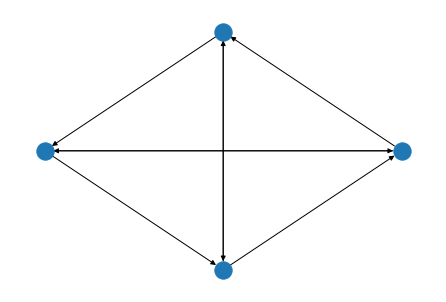

In [7]:
topo = rc[0].pull("topo", targets=0)
nx.draw_circular(topo)

We assume there are four agents and the topology used is Exponential 2 graph. What happened after `win_create` called is illustrated:
<img src="bf_win_create.png" alt="win_create.png" width="600"/> 

After this call, each process will allocate the number of incoming neighbor’s windows as buffer, which is illustrated in the figure as red square. Each buffer is dedicated to one neighbor. You don’t need to know which one is dedicated to which neighbor because these buffers are invisible to the python frontend. The only way to interact with them is through the win_update.

## Interacte with window object in BlueFog

Two basic operation to interact the data in the window is `win_get` and `win_put` operation. As their name indicate, they allow to put the data in local memory to window of the remote windows or get the data in remote memory into local window.

<img src="one-sided-getput.jpeg" alt="getput.jpeg" width="700"/>

win_get is one of three main methods to exchange the information between the processes in window. By default, it will get (fetch) the incoming neighbor’s local value into the its own buffer. Note it doesn’t need the sender to do anything.

In [8]:
%%px

if bf.rank() == 0:
    bf.win_get(name="x")
    print(x)  # the value of x is not changed.

[stdout:0] tensor([0., 0.])


As you see before, the value of `x` is still 0 afte the `win_get` operations from the neighbors. Why it don't update the value? It is because when you get the value from your neighbors, BlueFog do not update that value into the main window memory. Instead, it just put that value into the buffer of that window for future usage as shown in the following figure.

The main reason to design like this style is like non-blocking function:

> ```python
handle = bf.win_get_nonblocking(name="x")
SomeOperation(x)
bf.win_wait(handle)
> ```

Now, you should not worry about data racing problem -- whether the value `x` is applied some operation first or replaced by win_get value or in the mixing situation.


<img src="bf_win_get.png" alt="win_get.png" width="600"/> 

In order to interact with the value in the buffer, you have to explicitly call the `win_update` function, which is the bridge to connect the value of buffers (corresponding to the neighbor value) with the local value. It has two functionalities. One is to update the buffer to make sure that the neighbor value, which may be changed through win_put or win_get, is synchronized and visible to local memory. Another is it updates the local value to the average of self and neighbor’s value.

<img src="bf_win_update.png" alt="bf_win_update.png" width="600"/> 

In [9]:
%%px
bf.win_update(name="x")
print(f"{bf.rank()}: {x}")

[stdout:0] 0: tensor([1.6667, 1.6667])
[stdout:1] 2: tensor([2., 2.])
[stdout:2] 1: tensor([1., 1.])
[stdout:3] 3: tensor([3., 3.])


Now you see that the value of `x` in rank 0 is updated. (In four neighbor and exp2 graph case, it's value is 1.66 because $(0+2+3)/3$. Meanwhile, the value of `x` in other ranks are unchanged.

Similar as the `neighbor_allreduce` function, `win_get()` has `src_weights` argument to control the weight of receiving information and which neighbor to recieve the information.

In [10]:
%%px
y = (torch.FloatTensor([bf.rank()]))
assert bf.win_create(y, name="y")
if bf.rank() == 0:
    bf.win_get(src_weights={bf.size()-1: 0.5}, name="y")
    bf.win_update(name="y", self_weight=1.0, neighbor_weights={bf.size()-1: 0.4})
print(f"Rank {bf.rank()}: {y}")
assert bf.win_free(name="y")

[stdout:0] Rank 0: tensor([0.6000])
[stdout:1] Rank 2: tensor([2.])
[stdout:2] Rank 1: tensor([1.])
[stdout:3] Rank 3: tensor([3.])


Let's see the status of window object in above code step-by-step (assuming 4 nodes under exponential-2 graph):
1. All ranks create create a window with initial value: \[rank\]
2. For rank 0: 
    The window intialized \[0\] for self and \[0,0\] for neighbors.
    It called `win_get` the value from agent 3 only with weight 0.5. Hence, after this step the window object became:
    \[0\] for self and \[0, 1.5\].
3. For rank 0:
    It updates local value with self value 1.0 and neighbor weights 0.4 for rank 3, this produces $(0 \times 1.0 + 1.5  \times 0.4)=0.6$.
4. Last, all agents printed their local value. You saw the value of `x` is 0.4 as we calculated and freed the window.


There are another operations `win_put` shown in the next figure, which is very similar as `win_get`. So we leave the user to explore this function.

<img src="bf_win_put.png" alt="bf_win_put.png" width="600"/> 

# Asynchronous "Average Consensus" algorithm

Now you can use these window operation to build simple asynchonous Average Consensus. 

In [11]:
%%px
try:
    bf.win_free(name="x")
except:
    pass
# Set up the average consensus problem.
x = torch.randn(1, dtype=torch.double)
x_bar = bf.allreduce(x, average=True)

assert bf.win_create(x, name="x", zero_init=True)

In [12]:
%%px
def async_consensus_step(x):
    bf.win_put(x, name="x")
    bf.win_update(name="x")  # notice it is inplace update

In [13]:
x_bar = rc[0].pull("x_bar", block=True)
x_list = []
for i in range(15):
    %px async_consensus_step(x)
    x_list.append(rc[:].pull("x", block=True))

Text(0, 0.5, 'value')

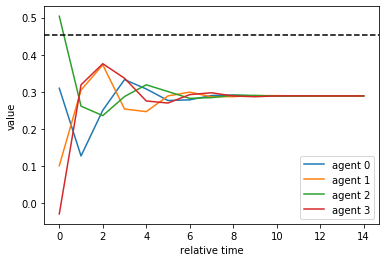

In [14]:
plt.plot(x_list)
plt.axhline(x_bar, linestyle="--", color="k")
plt.legend([f"agent {i}" for i in range(len(x_list[0]))])
plt.xlabel("relative time")
plt.ylabel("value")

You see from the above the figure that all agents reached some consensus value but that value is not the same as the mean of initial value. That is mainly because the asynchronous essense breaks the unbias property of average consensus algorithm. Fortunately, it is easy to correct its bias and the algorithm is the same push-sum algorithm we introduced in previous section.

# Asynchronous Push-Sum Consensus Algorithm

Recall the Push-Sum consensus algorithm in synchronized behavior is

For each agent $i$, run it in parallel:
$$
    x_{i, k+1} = \sum_{j\in \mathcal{N}_i} w_{ij}^{(k)} x_{j,k}\\
    p_{i, k+1} = \sum_{j\in \mathcal{N}_i} w_{ij}^{(k)} p_{j,k}\\
    y_{i, k+1} = x_{i, k+1} / p_{i, k+1}
$$

In asynchronous style, the mathametical equation becomes tricky to represent it. we are no longer able to use the global iteration/time $k$. Instead, we will use the logical event counter $e$, which acts similar as iteration $k$ but with different definition.

[TODO] Add a figure of global counter

There are two ways to descibe it -- with *push* view or *pull* view, one is based on the events that the data is pushed to the neighbors and another is based on the events that the data is recieved from neighbors. It is easy to describe the `push` view in words but not easy to write in words. So we will first use words to describte the push mode in words then give the equation description in equations: 

- Push view:<br />
    When at agent $i$ is ready to push a information: Split the data $x_i$ into $|\mathcal{N}_i|$ pieces. Each piece only holds the partial of $x_i$ according to the weights, i.e. $a_{ij} x_i$ and do the same thing for $p_i$ as well. Then push this information to the corresponding neighbors for adding. 
    
- Pull view:<br />
Let's use $e$ to denote the global event counter and assume that $j$ is the agent rank that triggers the event $e$.
\begin{align}
    x_{i, e+1} =&\; x_{i, e} + w_{ij}^{(k)} x_{j,k}\;\; {\rm if}\; i\neq j\;\; {\rm else}\; w_{jj} x_{j, e}\\
    p_{i, e+1} =&\; x_{i, e} + w_{ij}^{(k)} p_{j,k}\;\; {\rm if}\; i\neq j\;\; {\rm else}\; w_{jj} p_{j, e}\\
    y_{i, e+1} =&\; x_{i, e+1} / p_{i, e_i+1}
\end{align}

If you do not get the intuition of equations, it will be much clear if we re-write above equations over all agents by introducing the stacking matrix:

$$
    X_{e} = \left[ \begin{array}{c}
    -x^T_{1,e}- \\ 
    -x^T_{2,e}- \\ 
   \cdots \\
   -x^T_{N, e}-
  \end{array} \right]
$$

Under this notation, the first equation of **synchronous** mode is equivalent to 
$$
    X_{k+1} = W^{(k)} X_k
$$
where matrix $W^{(k)} = [w_{ij}]$ (it is doubly stochastic matrix).

The first equation of **asynchronous** mode is
$$
    X_{k+1} = W^{(e)} X_k
$$
where matrix $W^{(e)}$ is (again assuming $i'$ is the agent that trigger the event $e$.)
$$
    W^{(e)} = \left[ \begin{array}{ccccc}
    1 &      & w_{1i'} &   &\\
      &\ddots& \vdots &   &\\
      &      & w_{i'i'}   &   &\\
      &      & \vdots & \ddots&\\
      &      & w_{Ni'} &   & 1
  \end{array} \right]
$$
Note now that $W^{(e)}$ is no longer a doubly stochastic matrix but a column stochastic matrix, i.e. the summation of each column is 1 but not the sum of rows. One key property that you should verify, we call it mass conservation property, is 
$$
    \sum_{i} x_{i, e} =  \sum_{i} x_{i, e'},\;\; \forall e, e'
$$

It should be clear now that we need a new function called `win_accumulate`, which is similar to `win_put` that sends data to remote window object. But it accumulate (add) the value onto the remove window object instead of overwriting the data.
<img src="bf_win_accum.png" alt="bf_win_accumulate.png" width="600"/> 

Now let's use a simple example to illustrate the behavior of `win_accunulate`.

In [15]:
%%px
y = torch.DoubleTensor([bf.rank() + 1])
# zero_init will create the buffer with 0.
bf.win_create(y, name="y", zero_init=True)
if bf.rank() == 0:
    bf.win_accumulate(y, name="y")
if bf.rank() == 1:
    # neighbor_weights: Dict[int: float] -- rank to weight.
    bf.win_update(name="y", self_weight=1.0, neighbor_weights={0: 1.0})
    print(y)
bf.barrier()
if bf.rank() == 1:
    bf.win_update(name="y", self_weight=1.0, neighbor_weights={0: 1.0})
    print(y)

[stdout:2] 
tensor([2.], dtype=torch.float64)
tensor([3.], dtype=torch.float64)


First, the argument `self_weight` and `neighbor_weights` in `win_update` is the same as previous `neighbot_allreduce` argument. It controls the weights to do the update. In this case, we meant update the main memory of window `y` equals to its previous value times $1.0$ plus the buffer memory value for agent `0` with weights 1.0.

Hence, the first print you saw is $2.0$ because self value in main memory is initialized as $2$ and buffer value for neighbor is $0$ due to zero initialization. You may curious that isn't `bf.accumulate` of agent $0$ will accumulate value $1$ into the buffer? Actually it is not likely because note in agent `0` and `1` these two function is executed almost simultaneously. Hence, the buffer hasn't been updated yet. However, after we added `barrier` function, it is guaranteed that `win_update` in agent $0$ is finished. Hence, the second print funciton, you will see the value is 3 because the buffer value is updated into 1 at that time.

Now, let see how to build asynchronous push-sum algorithm:

In [16]:
%%px
# Set up the average consensus problem.
x = torch.randn(10, dtype=torch.double)
x_bar = bf.allreduce(x, average=True)
mse = [torch.norm(x-x_bar, p=2) / torch.norm(x_bar, p=2)]
p = torch.DoubleTensor([1.0])
x_ext = torch.cat([x, p], 0)
# Instead of initalize the buffer with same value as x_ext,
# we initialize it as zero for accumulation.
bf.win_create(x_ext, name="x_ext", zero_init=True) 
outdegree = len(bf.out_neighbor_ranks())
indegree = len(bf.in_neighbor_ranks())

dst_weights = {rank: 1.0 / (outdegree + 1) for rank in bf.out_neighbor_ranks()}
self_weight = 1/(1+outdegree)

But it is not enough with accumulate only. 
We designate the local buffer of one agent for all incoming neighbors. This means the `win_accumulate` from different agents sends to common destination agent is independent. This property is very crucial to algorithm implementation because you no longer need to consider the data racing problem between the two agents sends to common destinations.
On the other hand, it is possible that the `win_update` and the corresponding `win_accumulate` from other agents operate on the same window object *simulatenously*.
Since agent $k$ cannot know when the incoming neighbor agent $k'$ will execute the `win_accumulate`, it is impossible to write the code completely avoid that. Consider the following example, the `win_update` at Node 1 may read the old value or the updated value from Node 2, but you cannot control.

<img src="win_race.png" alt="win_race.png" width="400"/> 

This data racing can be problematic for the push-sum algorithm. It can easily break the key mass conservation property  of push-sum algorithm, i.e., the sum of $p$ and $x$ over all agent is always constant.


Fortunately, it is very easy to avoid this situation through the **distributed mutex**. It is same usage as normal mutext that when agent $k$ want to update its local window object it has to acquire the mutex first. If it cannot acquire the mutex. it has to wait until the mutex is available. The difference from the normal mutex is that this mutex can also be acquired by neighbor agents. Hence, when an agent $k'$ wants to accumulate some value to the remote window object at agent $k$, it has to acquire the mutex of agent $k'$ first as well.
To use this distributed mutex, you just need to set the `require_mutex` argument in `win_accumulate` to be True. (`win_put` and `win_get` have the same argument as well.)

Besides the `win_accumulate` which is the writing side of function, we also need to change the behavior of `win_update` for asynchronous push-sum as well, which is the reading side. One obvious thing is that we need to set `require_mutex` as true. A less obvious thing is that we need clean the buffer in the window. Note by default `win_update` only compute the average value between self and neighbors and leave the value in the buffer untouched. In this case, `win_accumulate` will continue adding the values. Instead, what we want is move the value from buffer to local value, i.e. let self value to be the sum of self and neighbor, and  let the neighbor value to be zero. It is doable though `win_update` with the proper `self_weight`, `neighbor_weigth` and `reset` argument. But it is boilerplate, so we introduce a new function `win_update_then_collect`.

Now we are ready to present the asynchronous push-sum algorithm:

In [17]:
%%px
def push_sum_alg(x, self_weight, dst_weights, name):
    global mse
    bf.win_accumulate(x, self_weight=self_weight,
                      dst_weights=dst_weights, name=name, require_mutex=True)
    bf.win_update_then_collect(name="x_ext")
    x, associated_p = x_ext[:-1], x_ext[-1]
    mse.append(torch.norm(x/associated_p-x_bar, p=2) / torch.norm(x_bar, p=2))
    return x_ext

In [18]:
for i in range(100):
    if i % 5 == 0:
        print(f"iteration {i}", end="\r")
    %px x_ext = push_sum_alg(x_ext, self_weight, dst_weights, name="x_ext")

In [19]:
%%px 
# Do not forget to sync at last!
bf.barrier()
bf.win_update_then_collect(name="x_ext")
x, associated_p = x_ext[:-1], x_ext[-1]
print(f"associated p at {bf.rank()} is {associated_p}")
mse.append(torch.norm(x/associated_p - x_bar, p=2) /
           torch.norm(x_bar, p=2))
assert bf.win_free(name="x_ext")

[stdout:0] associated p at 0 is 1.00427521234524
[stdout:1] associated p at 2 is 0.991455734193527
[stdout:2] associated p at 1 is 1.0000002021018388
[stdout:3] associated p at 3 is 1.004276265183896


Text(0.5, 0, 'Local update counts')

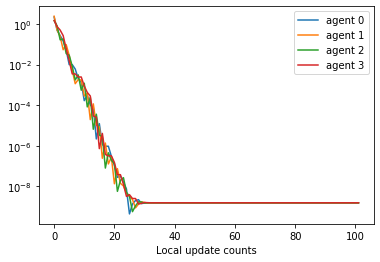

In [20]:
mse_list = rc[:].pull("mse")
for i, mse in enumerate(mse_list):
    plt.semilogy(mse, label="agent " + str(i))
plt.legend()
plt.xlabel("Local update counts")

# Asynchronous push-sum algorithm over the dynamic topology

Last, let's present the push-sum combining the asynchronous operation over dynamic topology.
The nice convergence property will gurantee that under very mild condition, push-sum algorithm will converge to the mean of all agents no matter what the order of asynchronous operations between agents is and how different the dynamic topologies change with time.

In [194]:
%%px
bf.win_free()

# Set up the average consensus problem.
x = torch.randn(10, dtype=torch.double)
x_bar = bf.allreduce(x, average=True)
mse = [torch.norm(x-x_bar, p=2) / torch.norm(x_bar, p=2)]
p = torch.DoubleTensor([1.0])
x_ext = torch.cat([x, p], 0)
# Instead of initalize the buffer with same value as x_ext,
# we initialize it as zero for accumulation.
bf.win_create(x_ext, name="x_ext", zero_init=True) 
outdegree = len(bf.out_neighbor_ranks())
indegree = len(bf.in_neighbor_ranks())

In [195]:
%%px
def dynamic_push_sum_alg(i, x, self_weight, dst_weights, name):
    global mse
    num_out_neighbors = len(bf.out_neighbor_ranks())
    sent_neighbor = bf.out_neighbor_ranks()[i % num_out_neighbors]
    dst_weights = {sent_neighbor: 0.5}
    self_weight = 0.5
    bf.win_accumulate(x, self_weight=self_weight,
                      dst_weights=dst_weights, name=name, require_mutex=True)
    bf.win_update_then_collect(name="x_ext")
    x, associated_p = x_ext[:-1], x_ext[-1]
    mse.append(torch.norm(x/associated_p-x_bar, p=2) / torch.norm(x_bar, p=2))
    return x_ext

In [196]:
for i in range(100):
    if i % 5 == 0:
        print(f"iteration {i}", end="\r")
    rc[:].push({"i": i})
    %px x_ext = dynamic_push_sum_alg(i, x_ext, self_weight, dst_weights, name="x_ext")

In [197]:
%%px 
# Do not forget to sync at last!
bf.barrier()
bf.win_update_then_collect(name="x_ext")
x, associated_p = x_ext[:-1], x_ext[-1]
print(f"associated p at {bf.rank()} is {associated_p}")
mse.append(torch.norm(x/associated_p - x_bar, p=2) /
           torch.norm(x_bar, p=2))
assert bf.win_free(name="x_ext")

[stdout:0] associated p at 1 is 0.9086710744042754
[stdout:1] associated p at 2 is 1.2607828511914492
[stdout:2] associated p at 0 is 0.5913289255957246
[stdout:3] associated p at 3 is 1.2392171488085506


Text(0.5, 0, 'Local update counts')

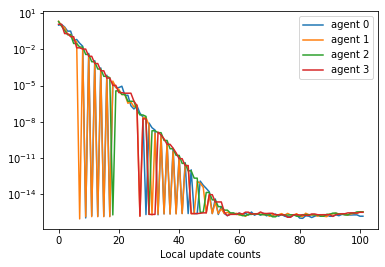

In [198]:
mse_list = rc[:].pull("mse")
for i, mse in enumerate(mse_list):
    plt.semilogy(mse, label="agent " + str(i))
plt.legend()
plt.xlabel("Local update counts")


# Other features

Similar as the `neighbor_allreduce`, we also provided the nonblocking version of all window functions, such as `win_put_nonblocking`, etc. We didn't illustrated in this notebook. The reader can try to use the nonblocking version of window operation to build an asynchronous Adapt-With-Combination algorithm, which combines nonblocking, asynchrnous, gradient, consensus communication features.